In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
def descente_gradient_auto(f,x0, n_étapes=15, ε=0.1, verbose = False,*, old_x=None, old_y=None):
	import mygrad as mg
	if old_x is None and old_y is None:
		try: 
			len(x0)
		except:
			x0 = np.array([x0])
		x_vect = [x0]
		y_vect = [f(x0)]
	else:
		print()
		x_vect = old_x
		y_vect = old_y
	x = mg.tensor(x_vect[-1])
	it = tqdm(range(1,n_étapes), desc="Déscente de gradient, étape ", disable = not verbose)
	for i in it:
		x = mg.tensor(x_vect[-1])
		f(x).backward()
		if verbose and i % int(n_étapes / 100 +1) == 0:
			it.set_description(f"Déscente de gradient, ||grad||_∞  : {ε * np.linalg.norm(x.grad,np.inf) :.3e}")
		if np.linalg.norm(x.grad,np.inf) == 0:
			from warnings import warn
			warn("Le gradient est trivial ! Il faudrait peut-être réduire théta pour pouvoir descendre")
			break
		x_vect.append(x - ε*np.asarray(x.grad))
		y_vect.append(f(x_vect[-1]))
	return np.array(x_vect), np.array(y_vect)

# Biais / phénomènes à regarder

## Pas de garanties de descente en toute généralité

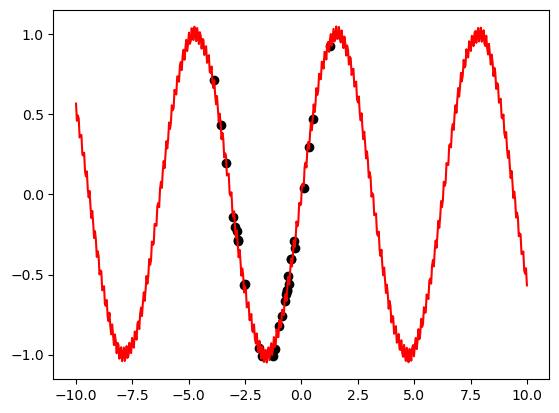

In [3]:
f = lambda x : np.sin(x) + 1/20 * np.sin(50*x)
x = np.linspace(-10,10,500)
y = f(x)
plt.plot(x,y, c="r")
x,y = descente_gradient_auto(f, x0=0.5, ε = np.random.random(), n_étapes=30)
plt.scatter(x,y, c="black")
plt.show()
# plt.plot(y, label="Évolution des valeurs de f")
# plt.title("La descente qui monte")
# plt.legend()
# plt.show()

# Méthodes de pertes (fin)

## MNIST

### Classification d'un chiffre

In [39]:
import urllib
url = "https://s3.amazonaws.com/img-datasets/mnist.npz"
path= "mnist.npz"
urllib.request.urlretrieve(url, path)
import numpy as np

with np.load(path, allow_pickle=True) as f:
    train_x, train_y = f['x_train'], f['y_train']
    test_x, test_y = f['x_test'], f['y_test']

Text(0.5, 1.0, '3')

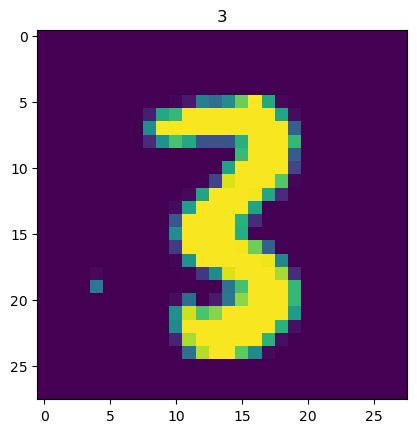

In [5]:
k = np.random.randint(len(train_x))
plt.imshow(train_x[k])
plt.title(train_y[k])

In [6]:
logistic = lambda x : 1/(1+np.exp(-x))
dlogistic = lambda x : np.exp(-x)/(1+np.exp(-x))**2
chiffre_préféré = 1
def loss(theta, X, Y, batch_size=-1, chiffre_préféré = chiffre_préféré):
	# num_data = len(Y)
	# num_features = len(theta) -1 # La dernière coordonnée est constante
	# flattened_X = X.reshape(num_data, -1)
	# assert X.shape[1] == num_features
	if batch_size <= 0:
		predictions = logistic(X@theta[:-1] + theta[-1])
		vérités = Y.reshape((len(Y),1)) == chiffre_préféré
		return np.mean((predictions - vérités)**2) # le modèle
	else:
		batch_indices = np.random.choice(len(train_x), batch_size, replace = False) # on choisit des indices aléatoirement
		return loss(theta, X[batch_indices], Y[batch_indices])

# pour tester que ça marche !
	# return Y.reshape((len(Y),1))
	# return flattened_X @theta[:-1]
# k = 2
# loss(theta, train_x[:k], train_y[:k])

In [7]:
batch_size = 100
train_loss = lambda theta : loss(theta, train_x.reshape(len(train_x),-1), train_y.reshape(-1,1), batch_size=batch_size)

In [8]:
x = [np.zeros(shape = (np.prod(train_x[0].shape)+1,1))]
y = [train_loss(x[0])]

In [9]:
theta = x[-1]
x,y = descente_gradient_auto(train_loss, theta, n_étapes = 5000, ε = 1e-8, verbose=1, old_x = list(x), old_y = list(y))

Déscente de gradient, ||grad||_∞  : 3.997e-08: 100%|██████████| 4999/4999 [00:13<00:00, 358.08it/s]


[]

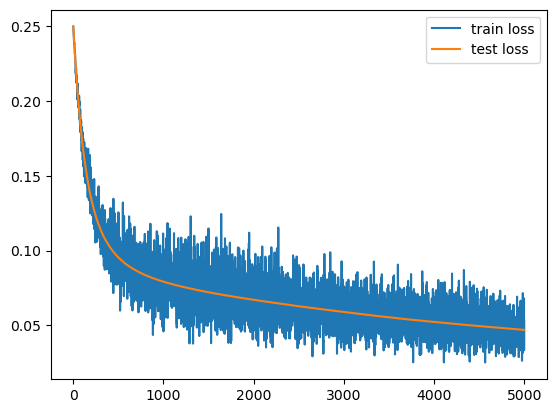

In [10]:
plt.plot(y, label = "train loss")
num_test_data = len(test_y)
test_indices = np.linspace(0,len(x)-1, 200, dtype=int)
plt.plot(test_indices,[loss(truc, test_x.reshape(num_test_data,-1), test_y.reshape(-1,1)) for i,truc in enumerate(x) if i in test_indices], label = "test loss")
plt.legend()
plt.plot()

In [11]:
last_theta = x[-1]
prédictions = logistic(test_x.reshape(len(test_x),-1)@last_theta[:-1] + last_theta[-1]) > .5
vérités = test_y.reshape(-1,1) == chiffre_préféré
accuracy = np.mean(prédictions == vérités )
print(f"Précision sur les données de test : {accuracy*100:.4}%")

Précision sur les données de test : 94.39%


### Classification de plusieurs chiffres

Il faut entrainer 10 classifieurs en même temps ! 

In [12]:
logistic = lambda x : 1/(1+np.exp(-x))
dlogistic = lambda x : np.exp(-x)/(1+np.exp(-x))**2
def loss(theta, X, Y, batch_size=-1):
	if batch_size <= 0:
		prédictions = logistic(X@theta[:-1] + theta[-1]).T
		vérités = np.asarray([Y.reshape((len(Y),1)) == chiffre for chiffre in range(10)]).squeeze()
		# return prédictions, vérités
		return np.mean((prédictions - vérités)**2, axis=None) # le modèle
	else:
		batch_indices = np.random.choice(len(train_x), batch_size)
		return loss(theta, X[batch_indices], Y[batch_indices])

train_loss = lambda theta : loss(theta, train_x.reshape(len(train_x),-1), train_y.reshape(-1,1), batch_size=batch_size)

In [13]:
x = [np.zeros(shape = (np.prod(train_x[0].shape)+1,10))]
y = [train_loss(x[0])]
x[0].shape

(785, 10)

In [14]:
# pred_, true_ = loss(x[-1], train_x.reshape(len(train_y),-1), train_y.reshape(-1,1), batch_size=2)

In [15]:
batch_size = 200
theta = x[-1]
x,y = descente_gradient_auto(train_loss, theta, n_étapes = 10_000, ε = 1e-8, verbose=1, old_x=list(x), old_y=list(y))

Déscente de gradient, ||grad||_∞  : 4.386e-08: 100%|██████████| 9999/9999 [00:20<00:00, 484.65it/s]


[]

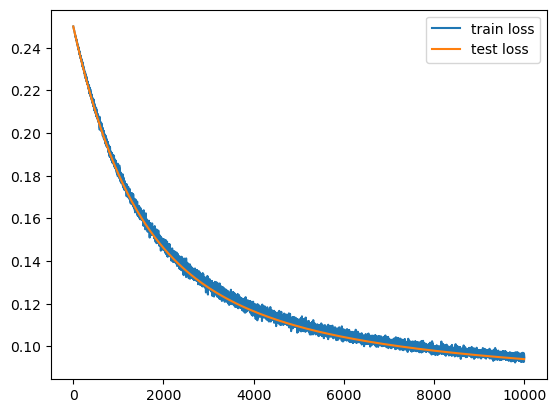

In [16]:
plt.plot(y, label = "train loss")
num_test_data = len(test_y)
test_indices = np.linspace(0,len(x)-1, 200, dtype=int)
plt.plot(test_indices,[loss(truc, test_x.reshape(num_test_data,-1), test_y.reshape(-1,1)) for i,truc in enumerate(x) if i in test_indices], label = "test loss")
plt.legend()
plt.plot()

In [17]:
theta = x[-1]

In [18]:
k = np.random.choice(len(test_x))
x_ = test_x[k].flatten()
y_ = test_y[k]
prédictions = logistic(x_@theta[:-1] + theta[-1]).T
# vérités = np.asarray(y_[y_.reshape((len(y_),1)) == chiffre for chiffre in range(10)]).squeeze()# loss(theta, x_,np.array([y_ == i for i in range(10)]))
print(f"Chiffre prédit : {np.argmax(prédictions)} versus le vrai chiffre : {y_}") # Prédiction vs vérité

Chiffre prédit : 0 versus le vrai chiffre : 5


In [19]:
prédictions = np.argmax(logistic(test_x.reshape(len(test_x), -1)@theta[:-1] + theta[-1]), axis=1)
vérités = test_y
accuracy = np.mean(prédictions == vérités )
print(f"Précision sur les données de test : {accuracy*100:.4}%")

Précision sur les données de test : 70.62%


Évidement, comme vu dans le cours, il ne **FAUT PAS** prendre ce modèle, il n'apprend que la "densité" de chaque chiffre !
Par exemple, il n'est pas 
 - invariant par translations
 - invariant par rotation
 
qui sont des propriétés **essentielles** pour la reconnaissance de caractères !

## Petit réseau de neurones 

In [20]:
import torch
def relu(x):
    x[x<=0] = 0
    x[x>=1] = 1
    return x
logistic = lambda x : 1/(1+np.e**(-x))
def linear_relu(x,A,b):
    return relu(linear(x,A,b))
def linear_logistic(x,A,b):
    return logistic(linear(x,A,b))
def linear(x,A,b):
    return x@A + b
def softmax(x):
    x = np.e**x
    return x / x.sum()
def model(x, As,bs):
    a1,a2,a3=As
    b1,b2,b3 = bs
    return softmax(linear_logistic(linear_relu(linear_logistic(x/x.max(),a1, b1),a2,b2), a3,b3))
r1,r2,r3 = 150,500,10
AAA = [torch.rand(28*28, r1, requires_grad=True)/(28*28), torch.rand(r1,r2, requires_grad=True)/r2, torch.rand(r2,r3, requires_grad=True)]
BBB = [torch.rand((r1), requires_grad=True)/r1, torch.rand(r2, requires_grad=True)/r2, torch.rand(r3, requires_grad=True)]

In [21]:
x0 = torch.from_numpy(test_x.reshape(len(test_x),-1)).type(torch.float32)
prediction = model(x0, AAA,BBB)
import torch.nn
vérités = torch.nn.functional.one_hot(torch.from_numpy(test_y).type(torch.int64),num_classes=10)
erreur = (prediction - vérités).mean()
torch.autograd.grad(erreur, [*AAA, *BBB]) # Les gradients de tous les As et tous les bs
# Et il faut continuer avec une descente de gradient + calibrer le learning rate ...

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[-1.1194e-21, -6.3921e-22, -1.1305e-21,  ..., -7.7728e-22,
          -9.9829e-22, -6.2438e-22],
         [-1.1176e-21, -6.3820e-22, -1.1287e-21,  ..., -7.7605e-22,
          -9.9671e-22, -6.2339e-22],
         [-1.1208e-21, -6.4001e-22, -1.1319e-21,  ..., -7.7824e-22,
          -9.9953e-22, -6.2516e-22],
         ...,
         [-1.1219e-21, -6.4069e-22, -1.1331e-21,  ..., -7.7907e-22,
          -1.0006e-21, -6.2582e-22],
         [-1.1228e-21, -6.4116e-22, -1.1339e-21,  ..., -7.7965e-22,
          -1.0013e-21, -6.2628e-22],
         [-1.1182e-21, -6.3857e-22, -1.1293e-21,  ..., -7.7649e-22,
          -9.9728e-22, -6.2375e-22]]),
 tensor([[-2.7450e-23, -3.2263e-23, -3.0794e-23,  ..., -3.8401e-23,
          -3.4044e-23, -

# Méthodes locales
## Méthodes basée sur les plus proches voisins

### Jeu de donnée : Anneau bruité

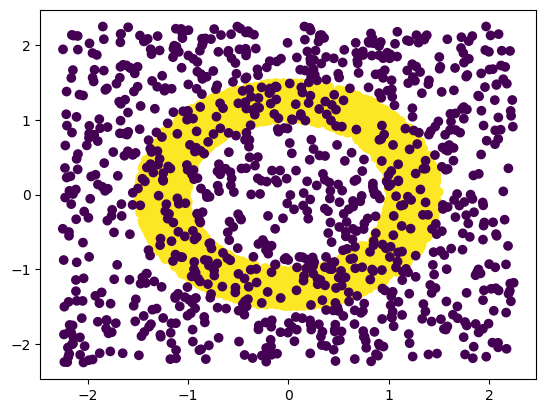

In [41]:
 # Remarque : On peut générer des points sur un anneau de manière bien plus efficace 
    #(cf Bercu-Chafai : Modélisation Stochastique et Simulations)
def anneau_bruité(n_anneau, n_bruit, dim=2, r1=1, r2=1.5, centre=None):
    set =[]
    while len(set)<n_anneau: 
        draw=np.random.uniform(low=-r2, high=2*r2, size=dim)
        if norm(draw) > r1 and norm(draw) < r2:
            set.append(draw)
    annulus = np.array(set) if centre == None else np.array(set) + np.array(centre)
    y_anneau = np.ones(shape = (n_anneau))
    diffuse_noise = uniform(size=(n_bruit,dim), low=-1.5*r2,high=1*r2*1.5)
    y_bruit = np.zeros(shape = (n_bruit))
    if centre is not None:	diffuse_noise += np.array(centre)
    return np.vstack([annulus, diffuse_noise]), np.hstack([y_anneau, y_bruit])
data, labels = anneau_bruité(5000,1000)
plt.scatter(data[:,0], data[:,1], c=labels)

## Prédiction par plus proches voisins

In [81]:
pts.shape

(10000, 2)

In [83]:
votes.shape

(2200,)

ValueError: 'c' argument has 5 elements, which is inconsistent with 'x' and 'y' with size 10000.

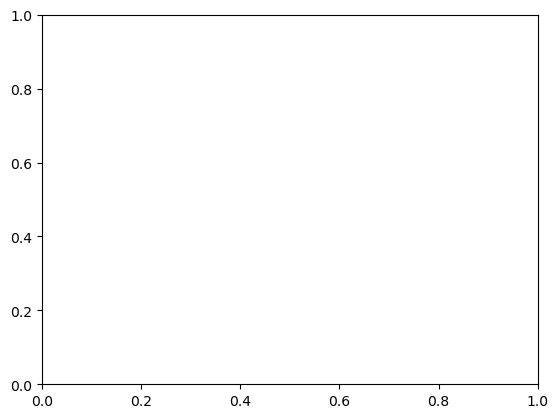

In [84]:
def knn_vote(xtest,xtrain,ytrain):
    from sklearn.metrics import pairwise_distances
    distances = pairwise_distances(xtest, xtrain)
    argknn = np.argsort(distances,axis=1)
    votes = [ytrain[argknn[i,:5]] for i in range(len(ytest))]
    votes = np.mean(votes, axis=0) > 0.5
    return votes
votes = knn_vote(pts,xtrain,ytrain)
plt.scatter(pts[:,0], pts[:,1], c=votes)

In [42]:
label = lambda x : 1 if (1 <= norm(x) <= 1.5) else 0 # les vrais labels (pour l'entrainement)

def predict_knn(xtest, k=5, xtrain=data, labels=None):
    from sklearn.metrics import pairwise_distances
    distances = pairwise_distances(xtest, xtrain)
    p = np.argsort(distances,axis=1)
    # vote = np.mean([label(truc) for truc in xtrain[p[:k]]]) if labels is None else np.mean(labels[p[:k]])
    v
    return int(vote>0.5)

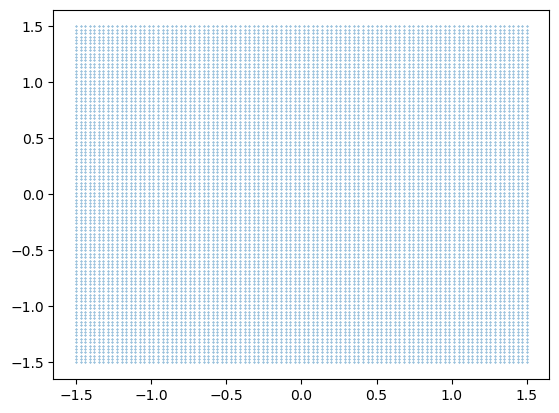

In [43]:
# Le jeu de donnée de test
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(-1.5, 1.5, 100)
xv, yv = np.meshgrid(x, y)
plt.scatter(xv,yv, s=0.1)
pts = np.vstack([xv.flatten(),yv.flatten()]).T

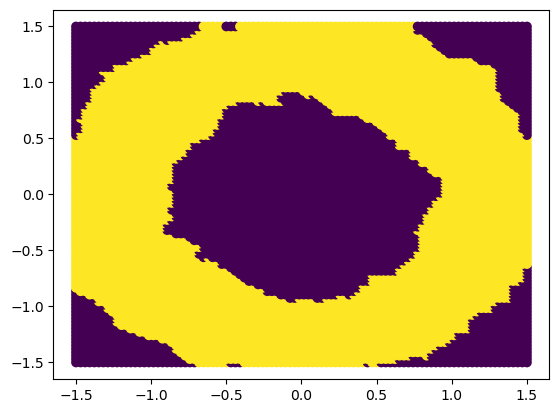

In [44]:
plt.scatter(pts[:,0], pts[:,1], c=[predict_knn(pt,k=10, labels=labels) for pt in pts])

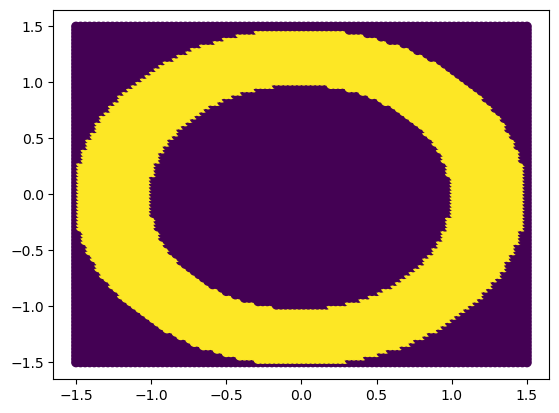

In [27]:
# La vérité
plt.scatter(pts[:,0], pts[:,1], c=[label(pt) for pt in pts])

### Accuracy ?

In [28]:
np.mean(np.array([predict_knn(pt, k=10, labels=labels) for pt in pts]) == np.array([label(pt) for pt in pts]))

0.8129

## Version sklearn

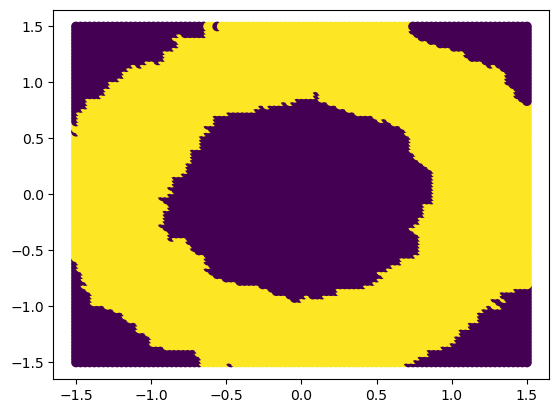

In [29]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(data, labels)
trux = clf.predict(pts)
plt.scatter(pts[:,0], pts[:,1], c=trux)

### Accuracy

In [30]:
clf.score(pts, [label(pt) for pt in pts])

0.8129

### Choix de k ?

**Sur les données d'entrainement**, on les découpe (encore) en train/test et on teste la performance d'un jeu de $k$ -> ça permet de choisir un $k$. On réentraine ensuite le classifieur avec ce $k$ sur les données d'entrainement.

Le "découpage" qui donne le plus de garanties théorique est un [k-fold](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e)

In [46]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [47]:
data, labels = anneau_bruité(10_000,1000)

In [52]:
ks = [1,2,3,5,10,20]
nsplit = 5
kf = KFold(n_splits=nsplit,shuffle=True)
scores = np.zeros((nsplit, len(ks)))
for i,[train, test] in enumerate(kf.split(data)):
    xtrain = data[train]
    ytrain = labels[train] #np.array([label(pt) for pt in xtrain])
    xtest = data[test]
    ytest = labels[test] # np.array([label(pt) for pt in xtest])
    for j,k in enumerate(ks):
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(xtrain, ytrain)
        scores[i,j]=clf.score(xtest, ytest)
scores_mean = np.mean(scores, axis=0)
scores_std = np.std(scores, axis=0)
p = np.argsort(scores_mean)[::-1]
print(*[f"Precision de k={ks[i]} en {nsplit}-fold : {scores_mean[i]*100:.3} ± {100*scores_std[i]:.3e}" for i in p], sep="\n")

Precision de k=3 en 5-fold : 97.5 ± 2.318e-01
Precision de k=5 en 5-fold : 97.3 ± 3.037e-01
Precision de k=10 en 5-fold : 97.0 ± 2.951e-01
Precision de k=20 en 5-fold : 96.5 ± 3.365e-01
Precision de k=1 en 5-fold : 96.0 ± 3.051e-01
Precision de k=2 en 5-fold : 94.3 ± 2.416e-01


Mais attention, si les données de test n'ont pas exactement la même tête, le meilleur choix peut être différent !

In [34]:
xtrain = data
ytrain = np.array([label(x) for x in data])
xtest = pts
ytest = np.array([label(x) for x in pts])
scores = np.zeros(len(ks))
for i,k in enumerate(ks):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(xtrain, ytrain)
    scores[i]=clf.score(xtest, ytest)
print(scores)

[0.891  0.8971 0.8449 0.8109 0.7633 0.7008]


### Version automatisée : GridSearchCV

In [35]:
xtrain = data
ytrain = labels #np.array([label(x) for x in data])
xtest = pts
ytest = np.array([label(x) for x in pts])

In [36]:
ks = [1,2,3,5,10,20] 
params = {"n_neighbors" : ks} # la grille de paramètres
knn_clf = KNeighborsClassifier()
gs_clf = GridSearchCV(knn_clf, params) # la validation croisée automatique de sklearn
gs_clf.fit(xtrain, ytrain) # entrainement
print(gs_clf.best_params_) # Les meilleurs paramètres
# print(gs_clf.cv_results_) # Les détails de la validation croisée

{'n_neighbors': 5}


## Prédiction par noyau

In [37]:
data, labels = anneau_bruité(10000,500)

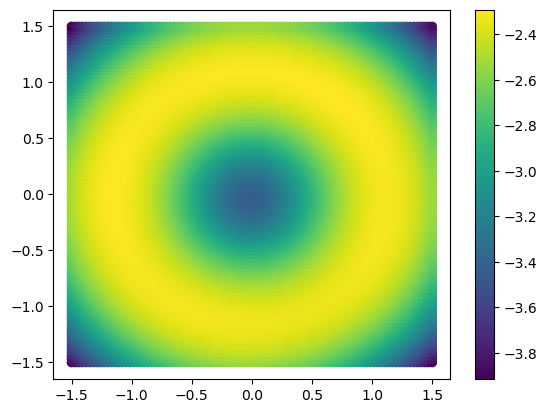

In [38]:
from sklearn.neighbors import KernelDensity
clf = KernelDensity(kernel="gaussian", bandwidth=0.5)
clf.fit(data, np.array([label(pt) for pt in data]))
trux = clf.score_samples(pts)
plt.scatter(pts[:,0], pts[:,1], c=trux)
plt.colorbar()

Il *"suffit"* de se choisir un seuil pour classifier (par exemple avec une gridsearch)